# LOS Prediction - LSTM for Time-Based Data

This notebook performs LOS prediction on data from the first X days from each patient. The goal is to utilize more of the dataset in order to see how the performance changes with respect to a standard DNN that only uses data from the first 24 or 48 hours.

In [0]:
###
#
# Imports Block
#
###

from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.advanced_activations import LeakyReLU
from google.colab import drive
import numpy as np

print(tf.__version__)

drive.mount('/content/drive')

1.15.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
###
#
# Data Import and Conversion to 3D Array
#
###
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
from sklearn.linear_model import SGDClassifier, SGDRegressor, LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from math import sqrt

# Consider imputing the data with values other than zero
raw_dataset = pd.read_csv('/content/drive/My Drive/Stanford/CS221/timestep.filtered.csv', header=0, index_col=0)
df = raw_dataset.copy()

# One hot encode the demographic columns
cols_to_one_hot = ['gender', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)
    #if col == "gender" or col == "insurance":
    #  df = df.join(one_hot)

los = df.pop('los').values
df.pop('status') # Not in use for this analysis
timesteps = df.pop('timestep') # Temporarily removed so we don't scale this

#
# Manual feature selection 
#
# print("Num rows in data: " + str(len(df)))
# print("Num columns before feature selection: " + str(len(df.columns)))
# df = df.filter(['Systolic', 'Diastolic', 'age', 'Anion Gap', 'Platelet Count', 'Heart Rate', 'O2-trend', 'Bicarbonate-trend', 'Phosphate', 'MCV-trend', 'White Blood Cells-trend', 'Neutrophils', 'Lactate', 'White Blood Cells', 'RDW', 'Lactate Dehydrogenase (LD)'])
# print("Num columns after feature selection: " + str(len(df.columns)))

#
# Normalize the dataset
#
train_stats = df.describe()
train_stats = train_stats.transpose()
scaled_features = StandardScaler().fit_transform(df.values)
df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

#
# Feature selection based on SGD
#
# print("Num rows in data: " + str(len(df)))
# print("Num columns before feature selection: " + str(len(df.columns)))
# clf = SGDRegressor(loss="squared_loss", penalty="l1", eta0=0.0001)
# sfm = SelectFromModel(clf, threshold=0.18)
# sfm.fit(df, los)
# feature_idx = sfm.get_support()
# df = df.loc[:,feature_idx]
# print("Num columns after feature selection: " + str(len(df.columns)))
# print(df.columns)

# df.insert(0, "timestep", timesteps, True)
# print(len(df.values))


#
# Feature selection based on f_regression
#
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
from statsmodels.stats.multitest import multipletests
print("Num rows in data: " + str(len(df)))
print("Num columns before feature selection: " + str(len(df.columns)))
sfm = SelectKBest(f_regression, k=64)
sfm.fit(df, los)
feature_idx = sfm.get_support()
df = df.loc[:,feature_idx]
print("Num columns after feature selection: " + str(len(df.columns)))
print(df.columns)

df.insert(0, "timestep", timesteps, True)
print(len(df.values))



Num rows in data: 51006
Num columns before feature selection: 141
Num columns after feature selection: 64
Index(['age', 'Bicarbonate', 'Hematocrit', 'Hemoglobin', 'Lymphocytes',
       'Monocytes', 'Platelet Count', 'Red Blood Cells', 'Urea Nitrogen',
       'White Blood Cells', 'Calculated Total CO2', 'pCO2', 'pH', 'pO2',
       'Phosphate', 'Oxygen Saturation', 'Oxygen', 'PEEP', 'Temperature',
       'Tidal Volume', 'Albumin', 'Alkaline Phosphatase', 'Bilirubin, Total',
       'Lactate Dehydrogenase (LD)', 'Potassium, Whole Blood', 'Free Calcium',
       'NS250', 'PANT40I', 'ASA81', 'NS500', 'VIAL', 'ALBU3H', 'BISA5', 'MVI',
       'DOCU100', 'NS/MBP100I', 'NS1000', 'PANT40', 'ONDAN4I', 'HEPA10SYR',
       'SENN187', 'KCL20PM', 'D5W100', 'NYST5L', 'METO50', 'METO25', 'HEPA5I',
       'NS100', 'MAG2PM', 'CHLO15L', 'CALG1I', 'LORA2I', 'IPRA2H', 'NACLFLUSH',
       'BISA10R', 'D5W250', 'OXYC5', 'MAGS1I', 'KCLBASE2', 'ASA325',
       'Systolic', 'O2 Flow.1', 'Temperature.1', 'O2'],
     

In [0]:

window_size = 5
max_sequence_length = 10
num_features = len(df.values[0]) - 1 # -1 accounts for the timestep column we are removing

lstm_input = []
lstm_los = []


##### CREATE A SQUARE MATRIX REPRESENTING PATIENT SEQUENCES WITH ONE OUTPUT #####
# 0,       0, x[0, 1], x[0, 2] -> y[0]
# 0, x[1, 1], x[1, 2], x[1, 3] -> y[1]
# This strategy uses stateless LSTM. We could use stateful LSTM and manually update at each timepoint in each patient 
# sequence, but this is extremely slow (note state is manually reset only after each patient sequence is finished). 
# https://github.com/umbertogriffo/Predictive-Maintenance-using-LSTM

# Data frame is assumed to be sorted in order of timesteps for each patient
vals = df.values
i = 0
while i < len(vals):
    row = vals[i]
    timestep = row[0]
    remaining_los = los[i]
    patient_sequence = []
    start_i = i
    i += 1
    # Skip until the next patient sequence
    while i < len(vals) and vals[i][0] != 0:
        i += 1
    end_i = i
    
    if end_i - start_i < window_size:
        # Consider removing these patient samples
        # Note: We need to front-pad the sequence with zeros in order to make sure we have a rectangular input
        for _ in range(window_size - (end_i - start_i)):
            patient_sequence.insert(0, [0] * num_features)
        r = start_i
        while r < end_i:
            patient_sequence.append(vals[r, 1:])
            r += 1

        #######################################################
        # COMMENT BELOW IF WE DON'T WANT TO KEEP SHORT SEQUENCES
        #######################################################
        #lstm_input.append(patient_sequence)
        #lstm_los.append(remaining_los - window_size)
    else:
        # Create our sliding window data
        for offset in range(min(max_sequence_length, (end_i - start_i) - window_size + 1)):
            patient_sequence = []
            r = start_i + offset
            while r < start_i + offset + window_size:
                patient_sequence.append(vals[r, 1:])
                r += 1
            lstm_input.append(patient_sequence)
            lstm_los.append(remaining_los - offset - window_size)

            #######################################################
            # COMMENT BELOW IF WE WANT TO USE SLIDING WINDOW
            #######################################################
            break
        
lstm_input = np.array(lstm_input)
lstm_los = np.array(lstm_los)
lstm_los_cat = [[1 if a[0] else 0, 1 if a[1] else 0] for a in zip(lstm_los <= 10.75, lstm_los > 10.75)]
lstm_los_cat = np.array(lstm_los_cat)

#######################################################
# UNCOMMENT BELOW IF WE WANT TO LIMIT NUM OF SAMPLES
#######################################################
# lstm_input = lstm_input[:2000, :]
# lstm_los = lstm_los[:2000]

print("Number of samples = " + str(len(lstm_los)))
#lstm_input[1]
# lstm_input[0][0]
# lstm_los[4]
print(lstm_los_cat)

Number of samples = 3440
[[1 0]
 [0 1]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [0]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
def build_model():
  # Notes:
  # - Use batch_input_shape=(batch_size, # timesteps, # features) param if using Stateful 
  #   (we're dynamically controlling the state at that point - ie. we can have varying sequence lengths)
    
  model = Sequential([
    #layers.LSTM(32, input_shape=(window_size, num_features), return_sequences=True, stateful=False, dropout=0.3, recurrent_dropout=0.3, recurrent_regularizer=regularizers.l1_l2(0.01, 0.01)),
    LSTM(32, input_shape=(window_size, num_features), return_sequences=True, dropout=0.5, stateful=False),
    
    LSTM(32, input_shape=(window_size, num_features), return_sequences=True, dropout=0.5, stateful=False),
    
    LSTM(32, input_shape=(window_size, num_features), dropout=0.5, stateful=False),
    # layers.Dropout(0.5, name='dropout_2'),
    #layers.Dense(64, activation='relu', input_shape=[num_features]),
    #layers.Dropout(0.5, name='dropout_2'),
    #layers.Dense(32, activation='relu', input_shape=[num_features]),
    Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_cnn():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size,num_features)))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2, padding='same'))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
  return model

def build_cnn_cat():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size,num_features)))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2, padding='same'))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model = build_model()
# model = build_cnn_cat()
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 5, 32)             12416     
_________________________________________________________________
lstm_20 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
lstm_21 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 29,089
Trainable params: 29,089
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 50

# # Batch size defaults to 32
# history = model.fit(
#   lstm_input, lstm_los,
#   batch_size=1,
#   epochs=EPOCHS, validation_split = 0.3, verbose=1,
#   callbacks=[PrintDot()])

#### CAT ####
# Batch size defaults to 32
history = model.fit(
  lstm_input, lstm_los,
  batch_size=1,
  epochs=EPOCHS, validation_split = 0.3, verbose=1)


Train on 2408 samples, validate on 1032 samples
Epoch 1/50
2408/2408 [==============================] - 53s 22ms/step - loss: 136.5065 - mean_absolute_error: 7.3205 - mean_squared_error: 136.5065 - val_loss: 113.9636 - val_mean_absolute_error: 7.1666 - val_mean_squared_error: 113.9636
Epoch 2/50
2408/2408 [==============================] - 42s 18ms/step - loss: 125.7112 - mean_absolute_error: 7.0578 - mean_squared_error: 125.7112 - val_loss: 111.0577 - val_mean_absolute_error: 6.9427 - val_mean_squared_error: 111.0577
Epoch 3/50
2408/2408 [==============================] - 42s 17ms/step - loss: 123.6122 - mean_absolute_error: 6.9999 - mean_squared_error: 123.6122 - val_loss: 107.0332 - val_mean_absolute_error: 6.9059 - val_mean_squared_error: 107.0332
Epoch 4/50
2408/2408 [==============================] - 41s 17ms/step - loss: 118.9969 - mean_absolute_error: 6.8365 - mean_squared_error: 118.9969 - val_loss: 106.8461 - val_mean_absolute_error: 6.7543 - val_mean_squared_error: 106.8461


In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
hist["val_mean_absolute_error"][3:].mean()

6.174688288051363

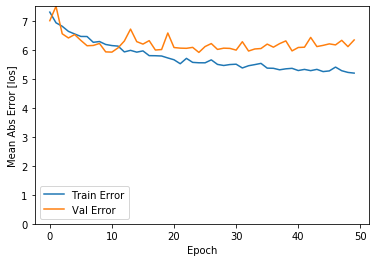

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [los]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,max(hist['val_mean_absolute_error'])])
  plt.legend()

  plt.show()


plot_history(history)
